# Class Switching Notebook

This notebook illustrates the use of the class switching ensemble classifier. We show that this classifier can have improved properties over using a single classifier and bagging. The individual classifiers are typically classification trees (default calssifier in bagging), although any other classifier may be used. We will evaluate the performance of this classifier on the Breast Cancer dataset and compare it with a single classification tree and a bagging ensemble of classification trees. Unfortunately, class switching is not implemented in scikit-learn. However, it is very easy to create such a custom ensemble classifier.

First, we import the required packages. These will be the standard ones, including autograd to compute gradients. 

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
import copy

## Defining the Class Switching Classifier

We define the class switching classifier by inheriting from BaseEstimator and ClassifierMixin.

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin

class ClassSwitching(BaseEstimator, ClassifierMixin):
    """ClassSwitching Ensemble Classifier"""

    def __init__(self, base_estimator, n_estimators, n_classes, p):

        """
        Called when initializing the classifier
        """

        # p is the probability of changing the labels
        
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator
        self.n_classes = n_classes
        self.p = p
        self.estimators = {}

        self.params = {'n_estimators': self.n_estimators}

        for i in range(n_estimators):
            self.estimators[ str(i) ] = copy.deepcopy(self.base_estimator)

    def get_params(self, deep=True):
        return self.params

    def fit(self, X, y=None):

        # We train the ensemble by generating perturbed datasets

        for i in range(self.n_estimators):
            
            # We randomly flip the labels of a fraction of the training data

            sel = np.random.choice(len(y), size = int(np.round(self.p * len(y))))
            new_labels = np.random.choice(self.n_classes, size = len(sel))
            new_labels[ new_labels == y[ sel ] ] = (new_labels[ new_labels == y[ sel ] ] + 1) % self.n_classes

            y_tmp = y.copy()
            y_tmp[ sel ] = new_labels
            self.estimators[ str(i) ].fit(X, y_tmp)

    def predict(self, X, y = None):
        
        # Prediction is done by majority voting

        predictions = np.ones((X.shape[ 0 ], self.n_estimators))
        classes = np.ones((X.shape[ 0 ], self.n_classes))

        for i in range(self.n_estimators):
            predictions[ :, i ] = self.estimators[ str(i) ].predict(X)

        for i in range(self.n_classes):
            classes[ :, i ] = np.sum(predictions == i, 1)

        return np.argmax(classes, 1)


## Loading the data

We load the data from a CSV file using pandas. The dataset considered is 'Wisconsin Diagnostic Breast Cancer' from the UCI repository. We ignore the first attribute in this dataset, which corresponds to the ID of each sample. The task of interest is to predict whether or not a cell corresponds to a malignant tumor. In this dataset all attributes take real values. These include area, smoothness, perimeter, etc.

In [10]:
data = pd.read_csv('wdbc.csv')
X = data.values[ :, 2:].astype(float)
y = (data.values[ :, 1 ] == 'B').astype(int)

## Performance Evaluation


We evaluate the performance of the bagging classifier on this dataset as a function of the ensemble size, and compare results with a single classification tree. We make extensive use of the pipeline framework of scikit-learn.

### Defining the Pipeline of Data Transformation and Estimation

We create a Pipeline for training the classifier in the cross validation procedure used to evaluate the performance. The ensemble size is set to 101, an odd number used to avoid ties in the voting process used to make predictions. This pipeline should include a standardization process too. This is omitted here since we will be working with classification trees in which the standardization process has no effect. We create another pipeline for the classification tree and for bagging.

In [11]:
ensemble_size = 101

# First class switching ensemble

pipeline_cs = Pipeline([ ('cs', ClassSwitching(base_estimator = \
    DecisionTreeClassifier(), n_estimators = ensemble_size, n_classes = 2, p = 0.2)) ])

# Next bagging

pipeline_bag = Pipeline([ ('bag', BaggingClassifier(estimator = \
    DecisionTreeClassifier(), n_estimators = ensemble_size)) ])

# In the single tree we use max-depth=4 since this gave good results previusly

pipeline_tree = Pipeline([ ('tree', DecisionTreeClassifier(max_depth = 4)) ])

### Defining the Data Splits and the Arrays to Store the Results

We create an object used to split the data and validate the performance of the pipeline created before. We also create arrays to store the test error of each method: the bagging ensemble and the single classification tree. We will average results 10 times (10 times 10-fold-stratified-cv) to reduce the variance of the results.

In [12]:
rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

# We will store here the results

accuracies_cs = np.zeros((100, ensemble_size))
accuracies_bag = np.zeros((100, ensemble_size))
accuracies_tree = np.zeros(100)

### Evaluating the Performance for each data split

We use stratified 10 fold cross-validation, to estimate the performance of the classifier. We use prediction accuracy as the evaluation metric. Other metrics can be considered as well. We will consider 10 splits of the data, corresponding to 10-fold-cv. This will be repeated 10 times, resulting in 100 folds.

In [13]:
split = 0

# We loop over the data partitions

for train_index, test_index in rkf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline_bag.fit(X_train, y_train)
    pipeline_cs.fit(X_train, y_train)
    
    # We evaluate the performance for each ensemble size

    for i in range(1, ensemble_size + 1, 1):
        pipeline_bag.set_params(bag__n_estimators=i)
        pipeline_cs.set_params(cs__n_estimators=i)

        accuracies_bag[ split, i - 1 ] = np.mean(pipeline_bag.predict(X_test) == y_test)
        accuracies_cs[ split, i - 1 ] = np.mean(pipeline_cs.predict(X_test) == y_test)

    # We evaluate the performance of the single tree
        
    pipeline_tree.fit(X_train, y_train)
    accuracies_tree[ split] = np.mean(pipeline_tree.predict(X_test) == y_test)

    split += 1

    print(split)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


### Obtaining the Average Results


We compute average error results alongside with the corresponding standard deviation estimates.

In [14]:
mean_errors_cs = np.mean(1.0 - accuracies_cs, 0)
std_mean_errors_cs = np.std(accuracies_cs, 0) / np.sqrt(100)

mean_errors_bag = np.mean(1.0 - accuracies_bag, 0)
std_mean_errors_bag = np.std(accuracies_bag, 0) / np.sqrt(100)

mean_error_tree = np.mean(1.0 - accuracies_tree)
std_mean_error_tree = np.std(accuracies_tree) / np.sqrt(100)

## Plotting the Results

We plot the average results obtained before. That is, the error of the bagging ensemble as a function of the ensemble size, and the error of a single tree. This error is plotted as an horizontal line.

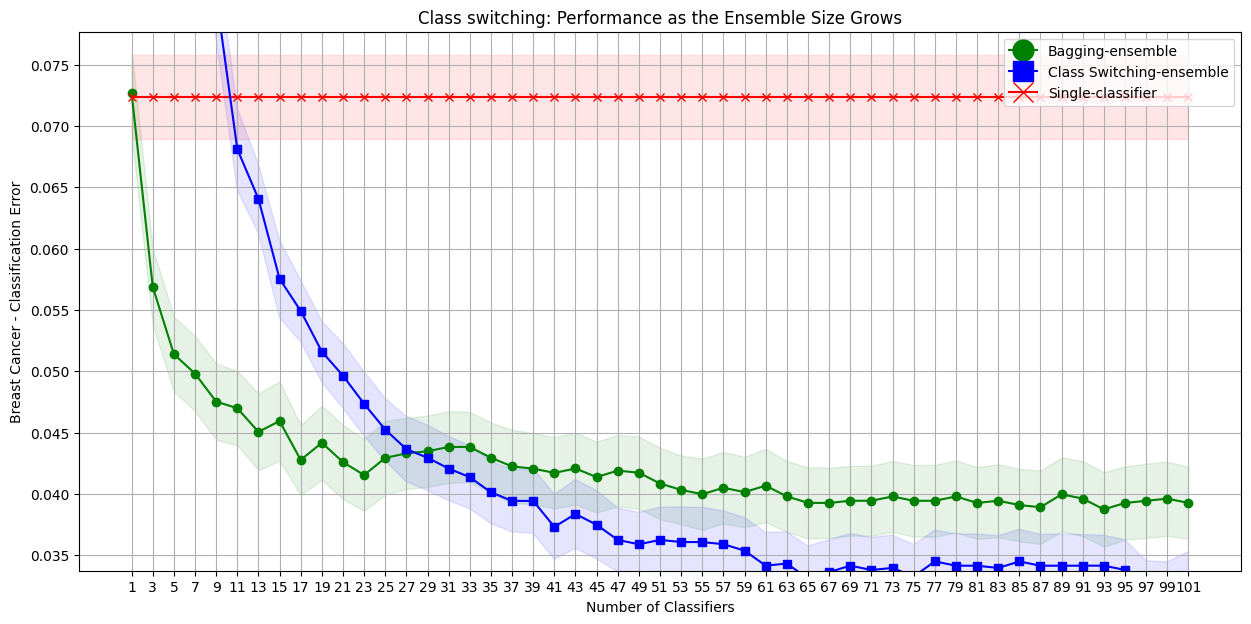

In [15]:
sel = np.arange(1, ensemble_size + 1, 2) - 1
n_estimators = np.arange(1, ensemble_size + 1, 1)

plt.figure(figsize=(15,7))
line1, = plt.plot(n_estimators[ sel ], mean_errors_bag[ sel ], 'o-', color="g")
line2, = plt.plot(n_estimators[ sel ], mean_error_tree * np.ones(len(sel)), 'x-', color="r")
line2, = plt.plot(n_estimators[ sel ], mean_errors_cs[ sel ], 's-', color="b")
plt.fill_between(n_estimators[ sel ], (mean_errors_bag - std_mean_errors_bag)[ sel ], \
    (mean_errors_bag + std_mean_errors_bag)[ sel ], alpha=0.1, color="g")
plt.fill_between(n_estimators[ sel ], (mean_errors_cs - std_mean_errors_cs)[ sel ], \
    (mean_errors_cs + std_mean_errors_cs)[ sel ], alpha=0.1, color="b")
plt.fill_between(n_estimators[ sel ], mean_error_tree * np.ones(len(sel)) \
        + std_mean_error_tree, mean_error_tree * np.ones(len(sel)) - std_mean_error_tree \
        , alpha=0.1, color="r")
plt.grid()
plt.title("Class switching: Performance as the Ensemble Size Grows")
plt.xlabel('Number of Classifiers')
plt.xticks(np.array(n_estimators[ sel ]))
plt.ylabel('Breast Cancer - Classification Error')
plt.ylim((np.min(mean_errors_bag[ sel ])) - 0.005, 0.005 + np.max(mean_errors_bag[ sel ]))
legend_handles = [ mlines.Line2D([], [], color='g', marker='o', \
                   markersize=15, label='Bagging-ensemble'),
                   mlines.Line2D([], [], color='b', marker='s', \
                   markersize=15, label='Class Switching-ensemble'),
                   mlines.Line2D([], [], color='r', marker='x', \
                   markersize=15, label='Single-classifier') ]
plt.legend(handles=legend_handles, loc = 1)
plt.show()


### Classification Frontier Visualization

We show how the decision boundaries of the classifier look like for a single tree and for the bagging ensemble. For simplicity, we only consider the first two attributes of the previous problem. We use all the available data.

In [16]:
X = X[:, [0, 1]]

We plot the data we are going to train the classifier on.

In [17]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

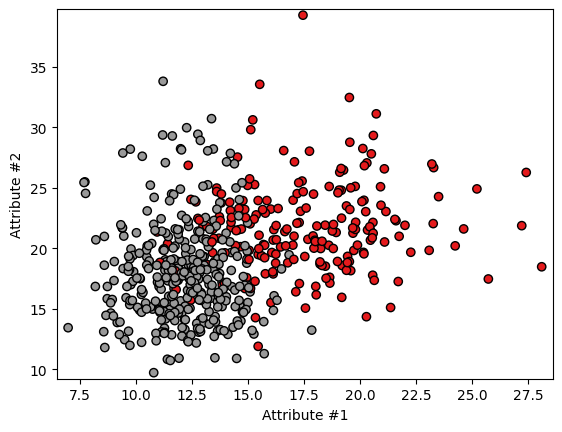

In [18]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, \
    edgecolor='k')
plt.xlabel('Attribute #1')
plt.ylabel('Attribute #2')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

We train the classifiers.

In [19]:
pipeline_bag.fit(X,y)
pipeline_cs.fit(X,y)
pipeline_tree.fit(X,y)

Pipeline(steps=[('tree', DecisionTreeClassifier(max_depth=4))])

We plot the resulting decision boundaries.

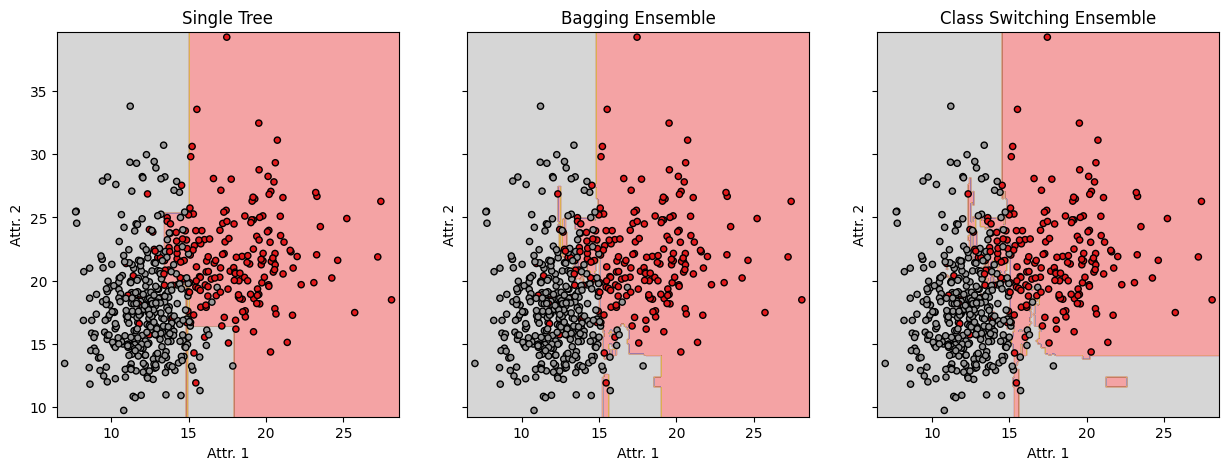

In [20]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15, 5))

Z = pipeline_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[0].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Set1)
axarr[0].set_title('Single Tree')
axarr[0].set_xlabel('Attr. 1')
axarr[0].set_ylabel('Attr. 2')

Z = pipeline_bag.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[1].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Set1)
axarr[1].set_title('Bagging Ensemble')
axarr[1].set_xlabel('Attr. 1')
axarr[1].set_ylabel('Attr. 2')

Z = pipeline_cs.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[2].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axarr[2].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Set1)
axarr[2].set_title('Class Switching Ensemble')
axarr[2].set_xlabel('Attr. 1')
axarr[2].set_ylabel('Attr. 2')

plt.show()

We observe that the frontier given by the bagging ensemble is slightly more complicated than that of a single tree. The frontier given by class switching is similar to that of bagging. Again, the disadvantage of the ensemble is that it decreases interpretability.

### Classification Frontier for Class Switching for Different Ensemble Sizes

We plot the frontiers obtained by class swithching for different values of the ensemble size. That is, we consdier $M=1,\ldots,201$ classifiers. We set $p=0.4$ to see the behavior of class switching more clear.

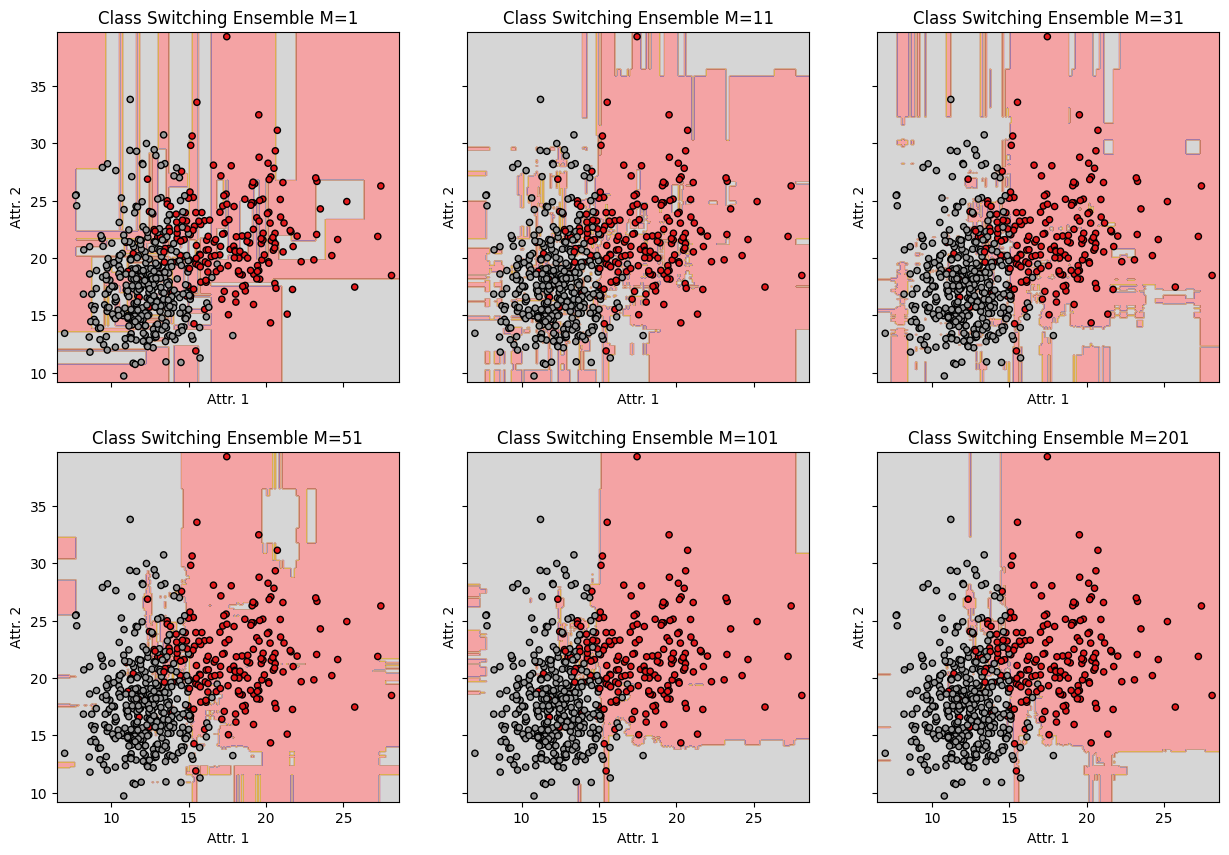

In [21]:
n_classifiers_to_use = np.array([ 1, 11, 31, 51, 101, 201 ])

pipeline_cs = Pipeline([ ('cs', ClassSwitching(base_estimator = \
    DecisionTreeClassifier(), n_estimators = np.max(n_classifiers_to_use), n_classes = 2, p = 0.4)) ])

f, axarr = plt.subplots(2, int(len(n_classifiers_to_use) / 2), sharex='col', sharey='row', figsize=(15, 10))

for i in range(len(n_classifiers_to_use)):
    
    u = int(i / 3)
    v = int(i % 3)

    pipeline_cs.set_params(cs__n_estimators = n_classifiers_to_use[ i ])
    pipeline_cs.fit(X,y)
    Z = pipeline_cs.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[ u, v ].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
    axarr[ u, v ].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.Set1)
    axarr[ u, v ].set_title('Class Switching Ensemble M=' + str(n_classifiers_to_use[ i ]))
    axarr[ u, v ].set_xlabel('Attr. 1')
    axarr[ u, v ].set_ylabel('Attr. 2')
    
plt.show()

We observe that when $M$ is small there are many regions in which the wrong label is predicted. That is because of the flipping of the class labels that happens in class switching. As we increase the ensemble size the decision boundaries become smoother.